In [1]:
#Import packages
#---------------------------------------
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import warnings
import random
import arviz as az
import pymc as pm
warnings.filterwarnings("ignore", category=RuntimeWarning) 

#Import your modules
#---------------------------------------
import admin_functions as adfn
import cell_decomp_func as cdfn

# Define paths
#----------------------------------------------------------------------
l_code = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
l_data = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
l_fig = '/Users/dominicburrows/Dropbox/PhD/figures/'

s_code = '/cndd3/dburrows/CODE/'
s_data = '/cndd3/dburrows/DATA/'

%load_ext autoreload
sys.version

'3.11.0 | packaged by conda-forge | (main, Jan 14 2023, 12:27:40) [GCC 11.3.0]'

## Simulate data for cell demixing

### Uniform -> Poisson rates
* Generate cells then mix into spots

In [3]:
#Define parameters of simulated data
n_clusts = 10
n_genes = 500
n_cells = 200
rate_range = 0,50 #max and min of uniform distribution for generating rates

#Simulate spot data from simulated gene expression
spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range)

#Simulate spot data from real gene expression data
#spot_real = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).real_gene_exp(cell_counts, clust_vec)

Loaded parameters: 10 cell types , 200 cells, & 500 genes.
Created spot mixtures from simulated data: 67 spots.


In [116]:
#Set parameters
n_clusts = 10
n_genes = 500
n_cells = 200
rate_range = 0,50 #max and min of uniform distribution for generating rates

#Simulate gene expression
cell_rate_mat, cell_counts, clust_vec = cdfn.sample_rates(n_clusts, n_cells, n_genes, rate_range)

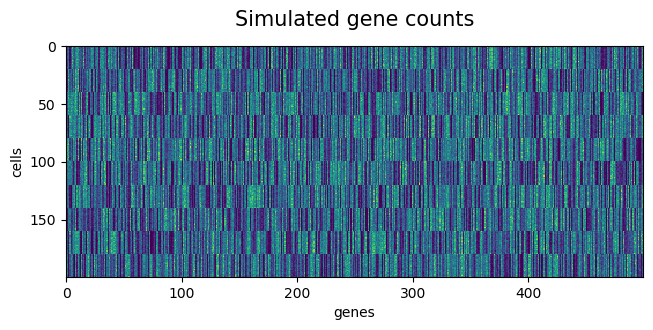

In [130]:
fig,ax = plt.subplots(figsize=(8,3))
ax.matshow(cell_counts)
ax.set_xlabel('genes')
ax.set_ylabel('cells')
ax.xaxis.tick_bottom()
ax.set_title('Simulated gene counts', size = 15)
plt.show()

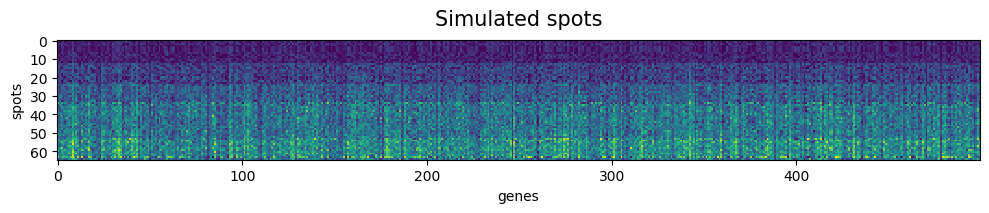

In [139]:
#Randomly mix into spots
n_spots, spots, prop_vec = cdfn.generate_spots(n_cells, n_clusts, cell_counts, clust_vec)

fig,ax = plt.subplots(figsize=(10,3))
ax.matshow(spots)
ax.set_xlabel('genes')
ax.xaxis.tick_bottom()
ax.set_ylabel('spots')
ax.set_title('Simulated spots', size = 15)
plt.tight_layout()
plt.show()

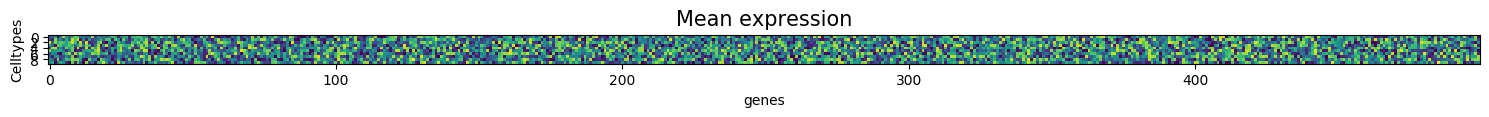

In [140]:
#Calculate mean gene expression from reference
mean_exps = cdfn.mean_exp(n_clusts, n_genes, cell_counts, clust_vec)

fig,ax = plt.subplots(figsize=(15,2))
ax.matshow(mean_exps)
ax.set_xlabel('genes')
ax.xaxis.tick_bottom()
ax.set_ylabel('Celltypes')
ax.set_title('Mean expression', size = 15)
plt.tight_layout()
plt.show()

### Exponential rates
* Model proportions and counts from exponential
* Explicity define variance within and across genes


Note that the negative binomial distribution has parameters $n$ and $p$,
which are related to the mean and variance:

$p=mean/variance < 1$

$n = mean^2 /(variance-mean)$

$mean = n(1-p)/p$

$variance = n(1-p)/p^2$


In [42]:
rng = np.random.default_rng(1)
def my_negbinom(m,overdispersion=1,rng=rng):  
    v = 1+m*overdispersion
    p=m/v
    n=m*m/(v-m)
    y=rng.negative_binomial(n=n,p=p)
    return y

In [43]:
# Simulate data
smoke_test=False

if smoke_test:
    C=4   # Cells
    S=20  # Visium sites
    G=100  # Genes
else:
    C=30   # Cells
    S=300  # Visium sites
    G=5000  # Genes

N,Nref=100,10       # Scaling factor for total library size for Visium and for cell type reference
rho=0.1 # Fraction of independent variation in cell type gene expression
r=4 # Dispersion parameter for negative binomial counts

# Cell type gene expression. For most genes, the gene expression is strongly correlated
# across all cell types. The expression level is the sum of a a shared component (0.9)
# and an independent component (0.1)
x = rng.exponential((1-rho)*N,size=(1,G))+rng.exponential(rho*N,size=(C,G))

# For a small fraction of genes (e.g. 5%), the gene expression is completely uncorrelated across cell types
Gde = int(0.2*G) # Fraction of DE genes
x[:,:Gde] = rng.exponential(N,size=(C,Gde))

# Weights of each cell type at each site. Interpret this as the number of cells of each type that show up
# at each site.
mu_cell = rng.exponential(2/C,size=(C)) # Mean number of cells at each site
W=my_negbinom(np.tile(mu_cell, (S,1)))

# Gene expression at each site
bgd = 10
mu_site=bgd+(W@x)
y=my_negbinom(mu_site)

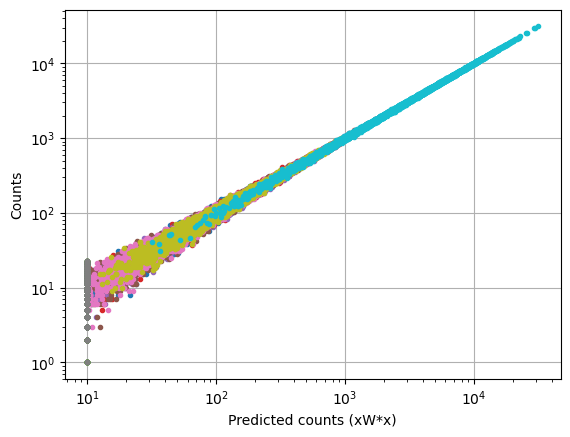

In [44]:
plt.loglog(mu_site[:10].T, y[:10].T,'.');
plt.xlabel('Predicted counts (xW*x)')
plt.ylabel('Counts')
plt.grid()

# Bayesian GLM for cell demixing
* Python implementation of RCTD 

### Basic linear regression noise model

In [2]:
# CPMs
%autoreload
#Define parameters of simulated data
n_clusts = 5
n_genes = 800
n_cells = 100
rate_range = 0,40 #max and min of uniform distribution for generating rates
per = 55 #percentage of dropped genes
e_std= 0 #spot + gene noise
g_std = 0 #gene specific noise
a_std = 0 #spot specific noise

In [3]:
#Simulate spot data from simulated gene expression
spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range)
n_spots = spot_sim.__dict__['n_spots']
spots = spot_sim.__dict__['spots']
ref_exp = spot_sim.__dict__['mean_exps']
prop_vec = spot_sim.__dict__['prop_vec']

spots = spots.astype(int) 

Loaded parameters: 5 cell types , 100 cells, & 800 genes.
Created spot mixtures from simulated data: 32 spots.


In [3]:
#Simple Linear regression

with pm.Model(coords={"celltypes": np.arange(n_clusts),
                      "spots": np.arange(n_spots),
                      "genes": np.arange(n_genes) }) as basic_model:
    
    #Declare data 
    mean_exp = pm.Data('mean_exp', ref_exp, mutable=False, dims=['celltypes','genes'])
    
    # Priors for unknown model parameters
    beta=pm.HalfNormal("beta", sigma=1, dims=['spots','celltypes'])
    
    lmd= pm.Deterministic('lmd', pm.math.dot(beta, mean_exp), dims=['spots','genes'])
    
    #Convert from proportions to counts
    N_g = pm.Data('N_g', np.sum(spots, 1).reshape(n_spots,1), mutable=False)

    #Likelihood of observed data given Poisson rates
    y=pm.Poisson("y", mu=lmd*N_g, observed=spots)

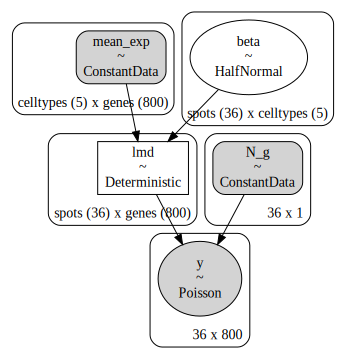

In [38]:
pm.model_to_graphviz(basic_model)

In [4]:
#Run model
with basic_model:
    idata=pm.sample(draws=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta]


ValueError: Not enough samples to build a trace.

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

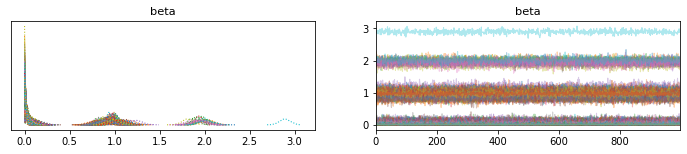

In [6]:
#Visualise posteriors across all proportions
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag
az.plot_trace(idata,combined=True)

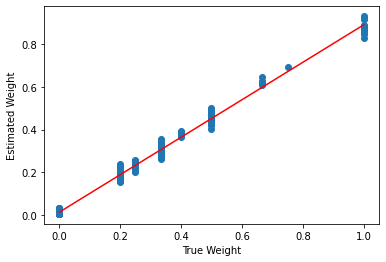

In [10]:
#Check performance
mean_post = np.mean(idata.posterior['beta'][0],axis=0)

#Calculate relative proportions
Nd = np.sum(mean_post, axis=1) 
Nd = np.asarray([Nd for i in range(n_clusts)]).T 

from scipy.stats import linregress
mean_post = np.divide(np.mean(idata.posterior['beta'][0],axis=0),Nd)

plt.scatter(np.ravel(prop_vec), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()

### Poisson noise model

In [ ]:
#COMPARING PERFORMANCE ACROSS NOISE

#==============================================================
def run_pyRCTD(idata, prop_vec):
#==============================================================
    mean_post = np.mean(idata.posterior['beta'][0],axis=0)
    from scipy.stats import linregress
    line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))
    return(mean_post, line_fit.rvalue**2)

# Run alpha noise

#Define parameters of simulated data
n_clusts = 5
n_genes = 800
n_cells = 100
rate_range = 0,40 #max and min of uniform distribution for generating rates
mode = 'alpha'
#per = 55 #percentage of dropped genes
# e_std= 0 #spot + gene noise
# g_std = 0 #gene specific noise

for a in alpha_list:
    #Simulate spot data from simulated gene expression
    spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range)
    n_spots = spot_sim.__dict__['n_spots']
    spots = spot_sim.__dict__['spots']
    ref_exp = spot_sim.__dict__['mean_exps']
    prop_vec = spot_sim.__dict__['prop_vec']
    spots = cdfn.add_noise(spots, per=None, a_std=a, g_std=None, e_std=None) #add in noise

    #Simple Linear regression
    with pm.Model(coords={"celltypes": np.arange(n_clusts),
                        "spots": np.arange(n_spots),
                        "genes": np.arange(n_genes) }) as basic_model:
        #Declare data 
        mean_exp = pm.Data('mean_exp', ref_exp, mutable=False, dims=['celltypes','genes'])
        # Priors for unknown model parameters
        beta=pm.HalfNormal("beta", sigma=1, dims=['spots','celltypes'])
        lmd= pm.Deterministic('lmd', pm.math.dot(beta, mean_exp), dims=['spots','genes'])
        #Convert from proportions to counts
        N_g = pm.Data('N_g', np.sum(spots, 1).reshape(n_spots,1), mutable=False)
        #Likelihood of observed data given Poisson rates
        y=pm.Poisson("y", mu=lmd*N_g, observed=spots)

    #Run model
    with basic_model:
        basic_data=pm.sample(random_seed=1,draws=200,chains=1, discard_tuned_samples=False)


    #Poisson noise
    with pm.Model(coords={"celltypes": np.arange(n_clusts),
                        "spots": np.arange(n_spots),
                        "genes": np.arange(n_genes),
                        "1": np.arange(1) }) as Poisson_noise_model:
        #Declare data 
        mean_exp = pm.Data('mean_exp', ref_exp, mutable=False, dims=['celltypes','genes'])
        # Priors for unknown model parameters
        beta=pm.HalfNormal("beta", sigma=1, dims=['spots','celltypes']) # celltype proportions
        alpha = pm.Normal("alpha", mu=0, sigma=1, dims=['spots','1']) # random noise at each spot
        lmd= pm.Deterministic('lmd', np.exp(alpha)*pm.math.dot(beta, mean_exp), dims=['spots','genes'])
        #Convert from proportions to counts
        N_g = pm.Data('N_g', np.sum(spots, 1).reshape(n_spots,1), mutable=False)

        #Likelihood of observed data given Poisson rates
        y=pm.Poisson("y", mu=lmd*N_g, observed=spots)

    with Poisson_noise_model:
        noise_data = pm.sample(random_seed=1,draws=200,chains=1, discard_tuned_samples=False)

    basic_post, basic_r2 = run_pyRCTD(basic_data, prop_vec)
    noise_post, noise_r2 = run_pyRCTD(noise_data, prop_vec)
    if len(str(a))<2:pref = '0' + str(a)
    else:pref= str(a)
    np.save(s_data + 'spatial_transcriptomics/RCTD-basic-model_'+ mode + '-' + pref + '.npy', prop_vec, basic_post, basic_r2)
    np.save(s_data + 'spatial_transcriptomics/RCTD-noise-model_' + mode + '-' + pref + '.npy', prop_vec, noise_post, noise_r2)


In [3]:
# Noise model - Linear regression with noise covariates
#standard params
#n_clusts = 10
#n_genes = 600
#n_cells = 500
#rate_range = 0,20
#dropout = 85%
#E_std = 9
#a_std = 6
#g_std = 8

#Define parameters of simulated data
n_clusts = 10
n_genes = 600
n_cells = 500
rate_range = 0,40 #max and min of uniform distribution for generating rates
per = 85 #percentage of dropped genes
e_std= 1 #spot + gene noise
g_std = 1 #gene specific noise
a_std = 1 #spot specific noise

In [4]:
#Simulate spot data from simulated gene expression
spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range)
n_spots = spot_sim.__dict__['n_spots']
spots = spot_sim.__dict__['spots']
ref_exp = spot_sim.__dict__['mean_exps']
prop_vec = spot_sim.__dict__['prop_vec']

#Dropout a certain percentage of genes
for i in range(spots.shape[0]):
    rand_ind = np.random.choice(np.arange(spots.shape[1]), size = int((per/100) * spots.shape[1]), replace=False) #random index for selecting
    spots[i,rand_ind]=0

#Add random noise and make int and remove negatives
spots = spots+np.random.normal(0, e_std, (spots.shape))

#gamma - over each gene
gamma = np.random.normal(0, g_std, (spots.shape[1]))
gamma_mat = np.asarray([gamma for i in range(spots.shape[0])]) #Repeat across columns for elementwise addition
spots = spots+gamma_mat

#alpha - over each spot
alpha = np.random.normal(0, a_std, (spots.shape[0]))
alpha_mat = np.asarray([alpha for i in range(spots.shape[1])]).T #Repeat across columns for elementwise addition
spots = spots+alpha_mat

spots = spots.astype(int) 
spots[spots < 0] = 0
spots +=1 #remove any zeros

Loaded parameters: 10 cell types , 500 cells, & 600 genes.
Created spot mixtures from simulated data: 168 spots.


In [29]:
#Poisson noise
with pm.Model(coords={"celltypes": np.arange(n_clusts),
                    "spots": np.arange(n_spots),
                    "genes": np.arange(n_genes),
                    "1": np.arange(1) }) as Poisson_noise_model:

    #Declare data 
    mean_exp = pm.Data('mean_exp', ref_exp, mutable=False, dims=['celltypes','genes'])
    # Priors for unknown model parameters
    beta=pm.HalfNormal("beta", sigma=1, shape=(n_spots, n_clusts)) # proportions of each cell at each spot
    eps=pm.Normal("eps", mu= 0, sigma=1,  dims=['spots', 'genes']) # random noise at each spot and gene
    gamma = pm.Normal("gamma", mu= 0, sigma=1, dims=['1','genes']) # random noise at each spot
    alpha = pm.Normal("alpha", mu= 0, sigma=1, dims=['spots','1']) # random noise at each spot
    lmd= pm.Deterministic('lmd', np.exp(alpha)*np.exp(gamma)*np.exp(eps)*pm.math.dot(beta, mean_exp), dims=['spots','genes'])
    #Convert from proportions to counts
    N_g = pm.Data('N_g', np.sum(spots, 1).reshape(n_spots,1), mutable=False)

    #Likelihood of observed data given Poisson rates
    y=pm.Poisson("y", mu=lmd*N_g, observed=spots)


In [6]:
Poisson_noise_model

 beta ~ N**+(0, 1)
  eps ~ N(0, 1)
gamma ~ N(0, 1)
alpha ~ N(0, 1)
  lmd ~ Deterministic(f(beta, eps, gamma, alpha))
    y ~ Pois(f(beta, eps, gamma, alpha))

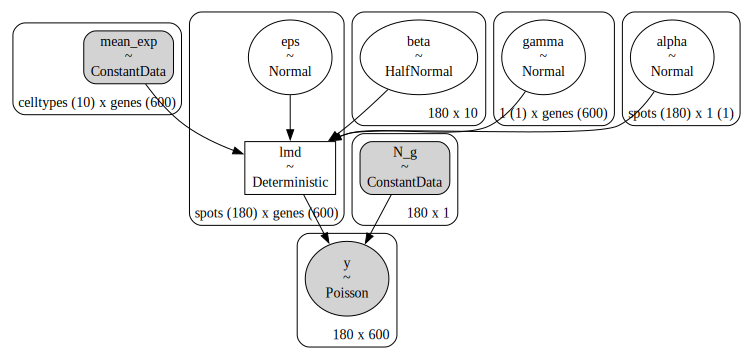

In [7]:
pm.model_to_graphviz(Poisson_noise_model)

In [35]:
#Run model
with Poisson_noise_GLM:
    idata=pm.sample(draws=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta, eps, gamma, alpha]


Sampling 1 chain for 375 tune and 0 draw iterations (375 + 0 draws total) took 3523 seconds.


In [29]:
e_std, g_std, a_std

(1, 1, 1)

KeyboardInterrupt: 

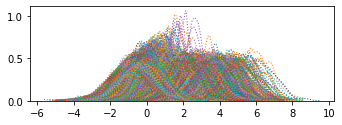

In [28]:
#Visualise posteriors across all proportions
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag
az.plot_trace(idata,combined=True)

In [31]:
line_fit.rvalue

0.48947244756820973

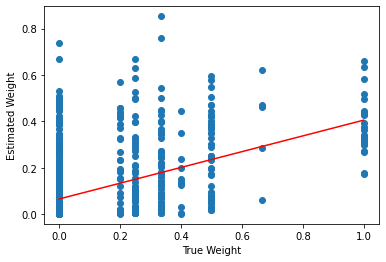

In [30]:
#Check performance
mean_post = np.mean(idata.posterior['beta'][0],axis=0)

#Calculate relative proportions
Nd = np.sum(mean_post, axis=1) 
Nd = np.asarray([Nd for i in range(n_clusts)]).T 

from scipy.stats import linregress
mean_post = np.divide(np.mean(idata.posterior['beta'][0],axis=0),Nd)

plt.scatter(np.ravel(prop_vec), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()

### Negative binomial model

In [ ]:
with pm.Model(coords={"cells":np.arange(C),
                      "genes":np.arange(G),
                      "sites":np.arange(S)}) as model:
    # Priors for unknown model parameters

    x_data=pm.Data('x_data',x,shape=(C,G),mutable=False,dims=['cells','genes'])
    
    mu_cell = pm.TruncatedNormal("mu_cell",mu=1,sigma=1,lower=0,dims=["cells"])
    # sigma_rho = pm.TruncatedNormal("sigma_rho",mu=1,sigma=1,lower=0,
    #                             shape=(C),dims=["cells"])    
    W = pm.TruncatedNormal("W",mu=mu_cell,sigma=mu_cell,lower=0,dims=["sites","cells"])
    
    bgd = pm.Exponential('bgd',lam=1)    # background counts
    # bgd = 0    # background counts

    # Expected value of outcome
    mu = pm.Deterministic("mu", bgd+pm.math.dot(W,x_data), dims=["sites","genes"])

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.NegativeBinomial("Y_obs",mu=mu,alpha=r,observed=y,dims=['sites','genes'])
#     sigma=pm.Exponential('sigma', lam=1)
#     Y_obs = pm.Normal("Y_obs",mu=mu,sigma=sigma,observed=y, dims=["sites","genes"])

# Model performance

### Adding noise to Poisson noise GLM

In [2]:
#gamma model - gene shared noise
# NORMAL PRIOR + NOISE
pref = 'alpha'
basic_l = adfn.return_files(s_data, 'spatial_transcriptomics', '*basic*model*' + pref + '*')
noise_l = adfn.return_files(s_data, 'spatial_transcriptomics', '*noise*model*' + pref + '*')
len(basic_l), len(noise_l)

(20, 20)

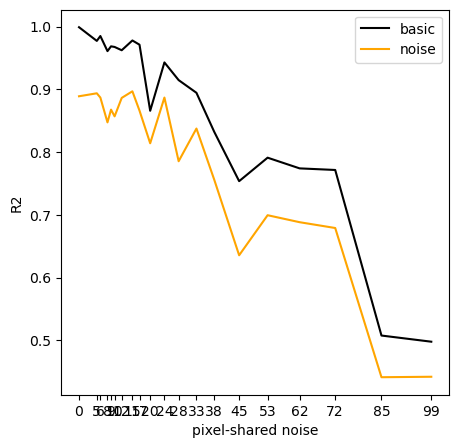

In [4]:
#drop out percentages
par_list = alpha_list = np.geomspace(5,100,20).astype(int)
par_list[0]=0

#Load basic model
curr_l = basic_l
basic_v = [np.load(curr_l[i], allow_pickle=True)[2] for i in range(len(curr_l))]
#Load noise model
curr_l = noise_l
noise_v = [np.load(curr_l[i], allow_pickle=True)[2] for i in range(len(curr_l))]

fig,ax = plt.subplots(figsize=(5,5))
plt.plot(par_list, basic_v, c='k', label = 'basic')
plt.plot(par_list, noise_v, c='orange', label = 'noise')
plt.xticks(par_list)
plt.xlabel('pixel-shared noise')
plt.ylabel('R2')
plt.legend()
plt.show()

In [6]:
#gamma model - gene shared noise
# NORMAL PRIOR + NOISE

pref = 'gamma'
basic_l = adfn.return_files(s_data, 'spatial_transcriptomics', '*basic*gauss*model*' + pref + '*')
noise_l = adfn.return_files(s_data, 'spatial_transcriptomics', '*noise*gauss*model*' + pref + '*')
len(basic_l), len(noise_l)

(20, 20)

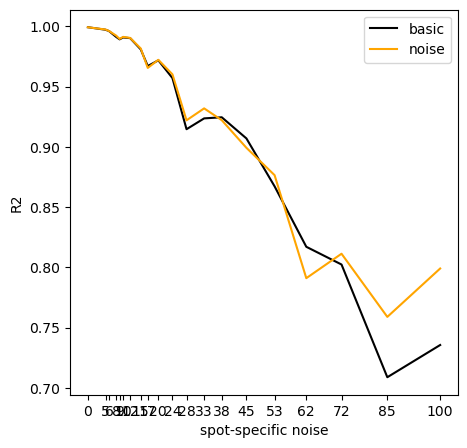

In [9]:
#drop out percentages
par_list = np.geomspace(5,100,20).astype(int)
par_list[0]=0

#Load basic model
curr_l = basic_l
basic_v = [np.load(curr_l[i], allow_pickle=True)[2] for i in range(len(curr_l))]
#Load noise model
curr_l = noise_l
noise_v = [np.load(curr_l[i], allow_pickle=True)[2] for i in range(len(curr_l))]

fig,ax = plt.subplots(figsize=(5,5))
plt.plot(par_list, basic_v, c='k', label = 'basic')
plt.plot(par_list, noise_v, c='orange', label = 'noise')
plt.xticks(par_list)
plt.xlabel('spot-specific noise')
plt.ylabel('R2')
plt.legend()
plt.show()

In [14]:
#gamma model - gene shared noise
# EXP PRIOR + NOISE

pref = 'gamma'
basic_l = adfn.return_files(s_data, 'spatial_transcriptomics', '*basic*exp*model*' + pref + '*')
noise_l = adfn.return_files(s_data, 'spatial_transcriptomics', '*noise*exp*model*' + pref + '*')
len(basic_l), len(noise_l)

(20, 20)

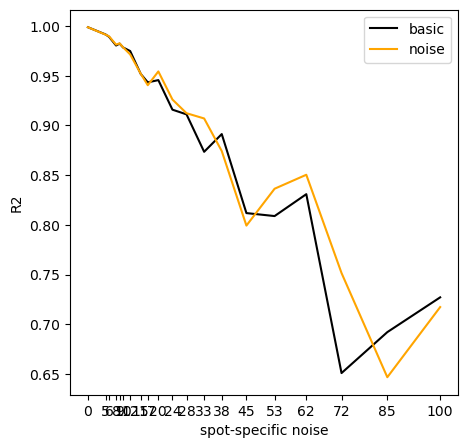

In [17]:
#drop out percentages
par_list = np.geomspace(5,100,20).astype(int)
par_list[0]=0

#Load basic model
curr_l = basic_l
basic_v = [np.load(curr_l[i], allow_pickle=True)[2] for i in range(len(curr_l))]
#Load noise model
curr_l = noise_l
noise_v = [np.load(curr_l[i], allow_pickle=True)[2] for i in range(len(curr_l))]

fig,ax = plt.subplots(figsize=(5,5))
plt.plot(par_list, basic_v, c='k', label = 'basic')
plt.plot(par_list, noise_v, c='orange', label = 'noise')
plt.xticks(par_list)
plt.xlabel('spot-specific noise')
plt.ylabel('R2')
plt.legend()
plt.show()

In [10]:
#gamma model - gene shared noise
# NORMAL PRIOR + NOISE

pref = 'eps'
basic_l = adfn.return_files(s_data, 'spatial_transcriptomics', '*basic*model*' + pref + '*')
noise_l = adfn.return_files(s_data, 'spatial_transcriptomics', '*noise*model*' + pref + '*')
len(basic_l), len(noise_l)

(20, 20)

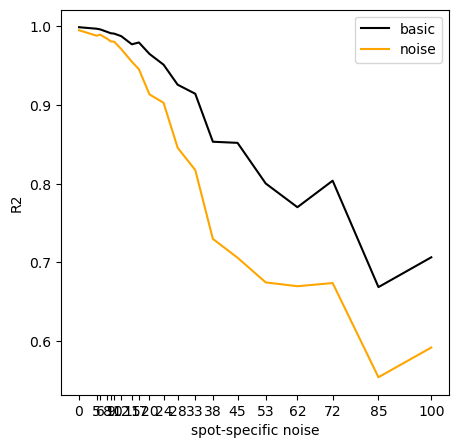

In [13]:
#drop out percentages
par_list = np.geomspace(5,100,20).astype(int)
par_list[0]=0

#Load basic model
curr_l = basic_l
basic_v = [np.load(curr_l[i], allow_pickle=True)[2] for i in range(len(curr_l))]
#Load noise model
curr_l = noise_l
noise_v = [np.load(curr_l[i], allow_pickle=True)[2] for i in range(len(curr_l))]

fig,ax = plt.subplots(figsize=(5,5))
plt.plot(par_list, basic_v, c='k', label = 'basic')
plt.plot(par_list, noise_v, c='orange', label = 'noise')
plt.xticks(par_list)
plt.xlabel('spot-specific noise')
plt.ylabel('R2')
plt.legend()
plt.show()

In [35]:
#gamma model - gene shared noise
# EXP PRIOR + NOISE

pref = 'eps'
basic_l = adfn.return_files(s_data, 'spatial_transcriptomics', '*basic*exp*model*' + pref + '*')
noise_l = adfn.return_files(s_data, 'spatial_transcriptomics', '*noise*exp*model*' + pref + '*')
len(basic_l), len(noise_l)

(20, 20)

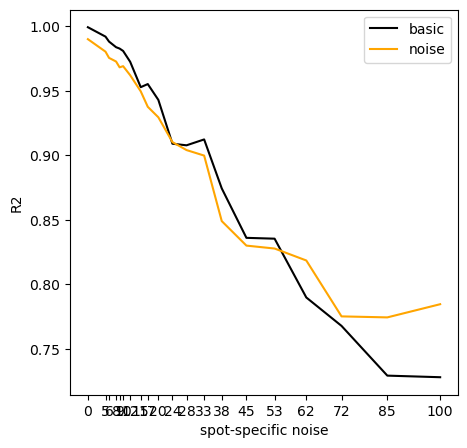

In [38]:
#drop out percentages
par_list = np.geomspace(5,100,20).astype(int)
par_list[0]=0

#Load basic model
curr_l = basic_l
basic_v = [np.load(curr_l[i], allow_pickle=True)[2] for i in range(len(curr_l))]
#Load noise model
curr_l = noise_l
noise_v = [np.load(curr_l[i], allow_pickle=True)[2] for i in range(len(curr_l))]

fig,ax = plt.subplots(figsize=(5,5))
plt.plot(par_list, basic_v, c='k', label = 'basic')
plt.plot(par_list, noise_v, c='orange', label = 'noise')
plt.xticks(par_list)
plt.xlabel('spot-specific noise')
plt.ylabel('R2')
plt.legend()
plt.show()

In [28]:
# pref = 'gamma'
# basic_l = adfn.return_files(s_data, 'spatial_transcriptomics', '*basic-model*' + pref + '*')
curr_l = basic_l

In [26]:
np.load(curr_l[i], allow_pickle=True)

array([[0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.        , 0.        , 0.        , 0.5       ],
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.5       , 0.5       ],
       [0.5       , 0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.        , 0.

In [29]:
for i in range(len(curr_l)):
    print(np.load(curr_l[i], allow_pickle=True).shape)

(32, 5)
(35, 5)
(33, 5)
(35, 5)
(37, 5)
(34, 5)
(35, 5)
(35, 5)


In [ ]:
#gamma model - gene shared noise

In [ ]:
#epsilon model - independent spot + gene noise

### Adding noise to Bayesian linear regression GLM

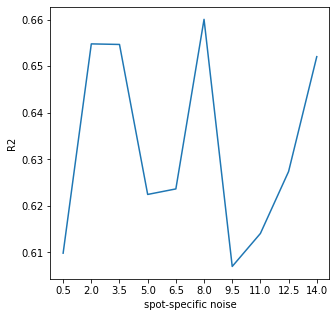

In [4]:
#drop out percentages
std_list = np.arange(0.5, 15, 1.5)
curr_l = adfn.return_files(s_data, 'SPATIAL-TRANSCRIPTOMICS', '*__gamma*')
out_l = [np.load(curr_l[i], allow_pickle=True)[2] for i in range(len(curr_l))]
par_range = std_list
fig,ax = plt.subplots(figsize=(5,5))
plt.plot(par_range, out_l)
plt.xticks(par_range)
plt.xlabel('spot-specific noise')
plt.ylabel('R2')
plt.show()

In [3]:
# Noise model - Linear regression with noise covariates
#standard params
#n_clusts = 10
#n_genes = 600
#n_cells = 500
#rate_range = 0,20
#dropout = 85%
#E_std = 9
#a_std = 6
#g_std = 8

#Define parameters of simulated data
n_clusts = 5
n_genes = 800
n_cells = 100
rate_range = 0,40 #max and min of uniform distribution for generating rates
per = 55 #percentage of dropped genes
e_std= 0 #spot + gene noise
g_std = 0 #gene specific noise
a_std = 0 #spot specific noise

In [3]:
alpha_noise = np.load(adfn.return_files(s_data, 'SPATIAL-TRANSCRIPTOMICS', '*PARSTAND_A-*')[0], allow_pickle=True)
gamma_noise = np.load(adfn.return_files(s_data, 'SPATIAL-TRANSCRIPTOMICS', '*PARSTAND_G-*')[0], allow_pickle=True)
eps_noise = np.load(adfn.return_files(s_data, 'SPATIAL-TRANSCRIPTOMICS', '*PARSTAND_E-*')[0], allow_pickle=True)
all_noise = np.load(adfn.return_files(s_data, 'SPATIAL-TRANSCRIPTOMICS', '*PARSTAND_AL*')[0], allow_pickle=True)

In [ ]:
alpha_noise[0]

In [25]:
idata = _noise[0]
#Visualise posteriors across all proportions
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag
az.plot_trace(idata,combined=True)

KeyboardInterrupt: 

In [4]:
alpha_noise[3], gamma_noise[3], eps_noise[3], all_noise[3]

(0.7807320658169278, 0.7080614931521894, 0.649095052485064, 0.5721295417584826)

In [9]:
alpha_noise[2]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.2       , 0.4       , ..., 0.2       , 0.        ,
        0.        ],
       [0.2       , 0.        , 0.2       , ..., 0.2       , 0.2       ,
        0.        ],
       [0.33333333, 0.33333333, 0.33333333, ..., 0.        , 0.        ,
        0.        ]])

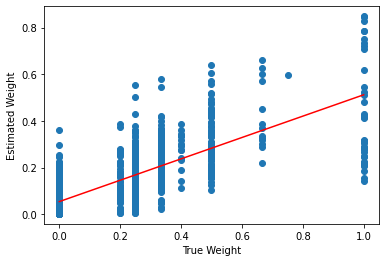

In [11]:
from scipy.stats import linregress
#Check performance
mean_post = alpha_noise[1]
prop = alpha_noise[2]

plt.scatter(np.ravel(prop), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()

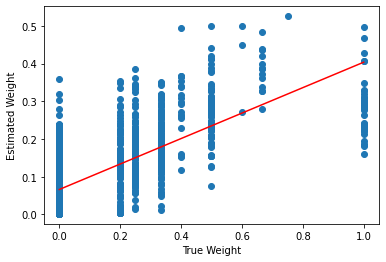

In [13]:
from scipy.stats import linregress
#Check performance
mean_post = gamma_noise[1]
prop = gamma_noise[2]

plt.scatter(np.ravel(prop), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()

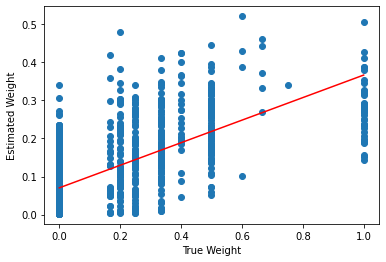

In [14]:
from scipy.stats import linregress
#Check performance
mean_post = eps_noise[1]
prop = eps_noise[2]

plt.scatter(np.ravel(prop), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()

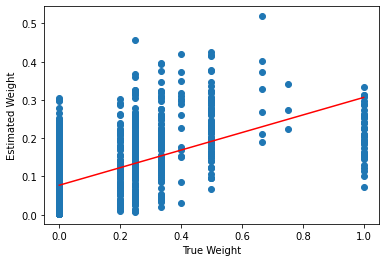

In [15]:
from scipy.stats import linregress
#Check performance
mean_post = all_noise[1]
prop = all_noise[2]

plt.scatter(np.ravel(prop), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()

In [4]:
clust_range = np.arange(3, 100, 10)
genes_range = np.arange(500, 10000, 1000)
cells_range = np.arange(500, 10000, 1000)
rate_rangel = np.arange(5, 100, 10)
clust_range, genes_range, cells_range, rate_rangel

(array([ 3, 13, 23, 33, 43, 53, 63, 73, 83, 93]),
 array([ 500, 1500, 2500, 3500, 4500, 5500, 6500, 7500, 8500, 9500]),
 array([ 500, 1500, 2500, 3500, 4500, 5500, 6500, 7500, 8500, 9500]),
 array([ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95]))

In [1]:
#standard spot generation
def run_pyRCTD(n_clusts, n_cells, n_genes, rate_range, per):
    #Simulate spot data from simulated gene expression
    spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range)
    n_spots = spot_sim.__dict__['n_spots']
    spots = spot_sim.__dict__['spots']
    ref_exp = spot_sim.__dict__['mean_exps']
    prop_vec = spot_sim.__dict__['prop_vec']

    spots +=1 #remove any zeros
    #Run without logs
    basic_model=pm.Model()
    with basic_model:
        beta=pm.HalfNormal("beta", sigma=1, shape=(n_spots, n_clusts))
        lmd=pm.math.dot(beta, ref_exp)    

        #Likelihood of observed data given Poisson rates
        y=pm.Poisson("y", mu=lmd, observed=spots)
    with basic_model:
        idata=pm.sample(draws=1000, chains=1)
    mean_post = np.mean(idata.posterior['beta'][0],axis=0)
    Nd = np.sum(mean_post, axis=1) 
    Nd = np.asarray([Nd for i in range(n_clusts)]).T 
    mean_post = np.divide(np.mean(idata.posterior['beta'][0],axis=0),Nd)
    from scipy.stats import linregress
    line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))
    return(mean_post, prop_vec, line_fit.rvalue)


In [ ]:
#dropout gene expression and add random noise
def run_pyRCTD_dropout_noise(n_clusts, n_cells, n_genes, rate_range, a_std):
    #Simulate spot data from simulated gene expression
    spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range)
    n_spots = spot_sim.__dict__['n_spots']
    spots = spot_sim.__dict__['spots']
    ref_exp = spot_sim.__dict__['mean_exps']
    prop_vec = spot_sim.__dict__['prop_vec']

    #Dropout a certain percentage of genes
    per = 85 #85% roughly what we see in real data
    for i in range(spots.shape[0]):
        rand_ind = np.random.choice(np.arange(spots.shape[1]), size = int((per/100) * spots.shape[1]), replace=False) #random index for selecting
        spots[i,rand_ind]=0
    
    e_std=9
    #Add random noise and make int and remove negatives
    spots = spots+np.random.normal(0, e_std, (spots.shape))

    g_std = 7
    #gamma - over each gene
    gamma = np.random.normal(0, g_std, (spots.shape[1]))
    gamma_mat = np.asarray([gamma for i in range(spots.shape[0])]) #Repeat across columns for elementwise addition
    spots = spots+gamma_mat

    #alpha - over each spot
    alpha = np.random.normal(0, a_std, (spots.shape[0]))
    alpha_mat = np.asarray([alpha for i in range(spots.shape[1])]).T #Repeat across columns for elementwise addition
    spots = spots+alpha_mat

    spots = spots.astype(int) 
    spots[spots < 0] = 0
    spots +=1 #remove any zeros
    #Run without logs
    basic_model=pm.Model()
    with basic_model:
        beta=pm.HalfNormal("beta", sigma=1, shape=(n_spots, n_clusts))
        lmd=pm.math.dot(beta, ref_exp)    

        #Likelihood of observed data given Poisson rates
        y=pm.Poisson("y", mu=lmd, observed=spots)
    with basic_model:
        idata=pm.sample(draws=1000, chains=1)
    mean_post = np.mean(idata.posterior['beta'][0],axis=0)
    Nd = np.sum(mean_post, axis=1) 
    Nd = np.asarray([Nd for i in range(n_clusts)]).T 
    mean_post = np.divide(np.mean(idata.posterior['beta'][0],axis=0),Nd)
    from scipy.stats import linregress
    line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))
    return(mean_post, prop_vec, line_fit.rvalue)


In [19]:
per_list = np.arange(5,95, 10)
per_list

array([ 5, 15, 25, 35, 45, 55, 65, 75, 85])

In [17]:
curr_l = adfn.return_files(s_data, 'SPATIAL-TRANSCRIPTOMICS', '*per*')
out_l = [np.load(curr_l[i], allow_pickle=True)[2] for i in range(len(curr_l))]

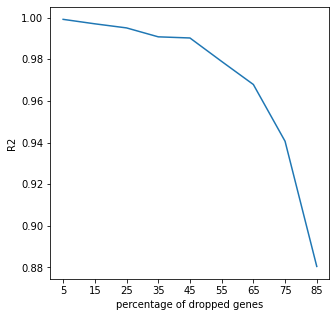

In [21]:
par_range = per_list
fig,ax = plt.subplots(figsize=(5,5))
plt.plot(par_range, out_l)
plt.xticks(par_range)
plt.xlabel('percentage of dropped genes')
plt.ylabel('R2')
plt.show()

In [24]:
np.load(curr_l[-1], allow_pickle=True)[1]

(176, 10)

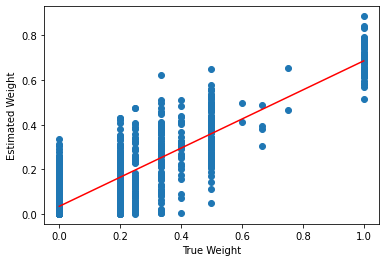

In [30]:
from scipy.stats import linregress
#Check performance
mean_post = np.load(curr_l[-1], allow_pickle=True)[0]

plt.scatter(np.ravel(np.load(curr_l[-1], allow_pickle=True)[1]), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(np.load(curr_l[-1], allow_pickle=True)[1]), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()

In [44]:
rates_list = np.geomspace(3,40, 8).astype(int)
rates_list

array([ 3,  4,  6,  9, 13, 19, 27, 40])

In [45]:
curr_l = adfn.return_files(s_data, 'SPATIAL-TRANSCRIPTOMICS', '*per*rates*')
out_l = [np.load(curr_l[i], allow_pickle=True)[2] for i in range(len(curr_l))]

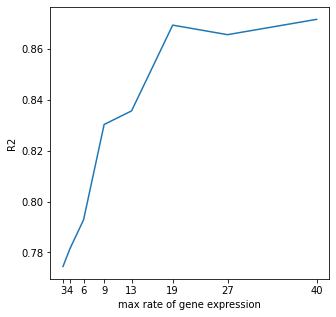

In [46]:
par_range = rates_list
fig,ax = plt.subplots(figsize=(5,5))
plt.plot(par_range, out_l)
plt.xticks(par_range)
plt.xlabel('max rate of gene expression')
plt.ylabel('R2')
plt.show()

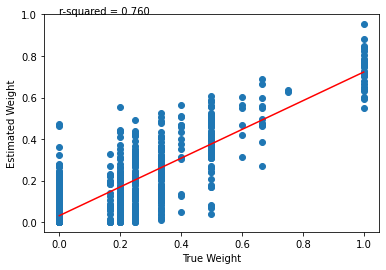

In [47]:
from scipy.stats import linregress
#Check performance
mean_post = np.load(curr_l[-1], allow_pickle=True)[0]

plt.scatter(np.ravel(np.load(curr_l[-1], allow_pickle=True)[1]), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(np.load(curr_l[-1], allow_pickle=True)[1]), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()

In [58]:
#gaussian noise applied to all spots
std_list = np.arange(0.5, 20, 2)
std_list

array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5])

In [59]:
curr_l = adfn.return_files(s_data, 'SPATIAL-TRANSCRIPTOMICS', '*gau*')
out_l = [np.load(curr_l[i], allow_pickle=True)[2] for i in range(len(curr_l))]


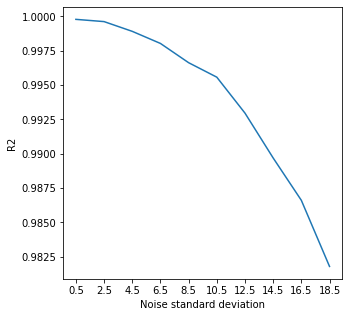

In [60]:
par_range = std_list
fig,ax = plt.subplots(figsize=(5,5))
plt.plot(par_range, out_l)
plt.xticks(par_range)
plt.xlabel('Noise standard deviation')
plt.ylabel('R2')
plt.show()

In [3]:
#drop out percentages
std_list = np.arange(0.5, 50, 4)
std_list

array([ 0.5,  4.5,  8.5, 12.5, 16.5, 20.5, 24.5, 28.5, 32.5, 36.5, 40.5,
       44.5, 48.5])

In [ ]:
curr_list = std_list
savepref = 'percent-0s-85_gauss-noise-std'

for l in curr_list:
#Define parameters of simulated data
    n_clusts = 10
    n_genes = 600
    n_cells = 500
    
    rate_range = 0,20 #max and min of uniform distribution for generating rates

    mean_post, prop_vec, r2 = run_pyRCTD_e(n_clusts, n_cells, n_genes, rate_range, l)
    savename = 'RCTD-test_' + savepref + '-' + str(l) + '.npy'
    np.save(s_data + 'SPATIAL-TRANSCRIPTOMICS/' + savename, [mean_post, prop_vec, r2])
    print(l)


In [9]:
curr_l = adfn.return_files(s_data, 'SPATIAL-TRANSCRIPTOMICS', '*per*gauss*')
out_l = [np.load(curr_l[i], allow_pickle=True)[2] for i in range(len(curr_l))]

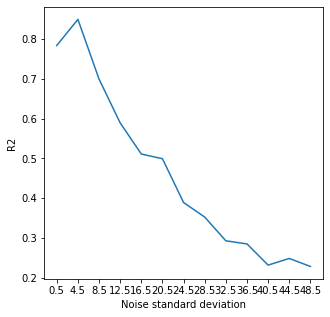

In [10]:
par_range = std_list
fig,ax = plt.subplots(figsize=(5,5))
plt.plot(par_range, out_l)
plt.xticks(par_range)
plt.xlabel('Noise standard deviation')
plt.ylabel('R2')
plt.show()

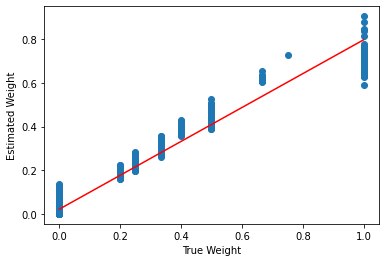

In [61]:
from scipy.stats import linregress
#Check performance
mean_post = np.load(curr_l[-1], allow_pickle=True)[0]

plt.scatter(np.ravel(np.load(curr_l[-1], allow_pickle=True)[1]), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(np.load(curr_l[-1], allow_pickle=True)[1]), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()

In [7]:
#drop out percentages
std_list = np.arange(0.5, 25, 2)

In [8]:
curr_l = adfn.return_files(s_data, 'SPATIAL-TRANSCRIPTOMICS', '*D_alpha*')
out_l = [np.load(curr_l[i], allow_pickle=True)[2] for i in range(len(curr_l))]
curr_l

['RCTD-test_PARSTAND_alpha-std-0.5.npy',
 'RCTD-test_PARSTAND_alpha-std-02.5.npy',
 'RCTD-test_PARSTAND_alpha-std-04.5.npy',
 'RCTD-test_PARSTAND_alpha-std-06.5.npy',
 'RCTD-test_PARSTAND_alpha-std-08.5.npy',
 'RCTD-test_PARSTAND_alpha-std-10.5.npy',
 'RCTD-test_PARSTAND_alpha-std-12.5.npy',
 'RCTD-test_PARSTAND_alpha-std-14.5.npy',
 'RCTD-test_PARSTAND_alpha-std-16.5.npy',
 'RCTD-test_PARSTAND_alpha-std-18.5.npy',
 'RCTD-test_PARSTAND_alpha-std-20.5.npy',
 'RCTD-test_PARSTAND_alpha-std-22.5.npy',
 'RCTD-test_PARSTAND_alpha-std-24.5.npy']

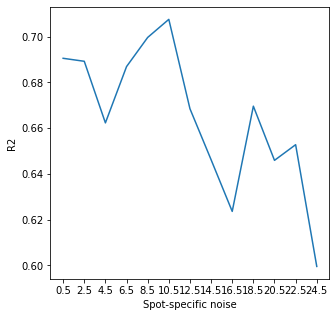

In [9]:
par_range = std_list
fig,ax = plt.subplots(figsize=(5,5))
plt.plot(par_range, out_l)
plt.xticks(par_range)
plt.xlabel('Spot-specific noise')
plt.ylabel('R2')
plt.show()

In [10]:
curr_l = adfn.return_files(s_data, 'SPATIAL-TRANSCRIPTOMICS', '*D_gamma*')
out_l = [np.load(curr_l[i], allow_pickle=True)[2] for i in range(len(curr_l))]
curr_l

['RCTD-test_PARSTAND_gamma-std-0.5.npy',
 'RCTD-test_PARSTAND_gamma-std-02.5.npy',
 'RCTD-test_PARSTAND_gamma-std-04.5.npy',
 'RCTD-test_PARSTAND_gamma-std-06.5.npy',
 'RCTD-test_PARSTAND_gamma-std-08.5.npy',
 'RCTD-test_PARSTAND_gamma-std-10.5.npy',
 'RCTD-test_PARSTAND_gamma-std-12.5.npy',
 'RCTD-test_PARSTAND_gamma-std-14.5.npy',
 'RCTD-test_PARSTAND_gamma-std-16.5.npy',
 'RCTD-test_PARSTAND_gamma-std-18.5.npy',
 'RCTD-test_PARSTAND_gamma-std-20.5.npy',
 'RCTD-test_PARSTAND_gamma-std-22.5.npy',
 'RCTD-test_PARSTAND_gamma-std-24.5.npy']

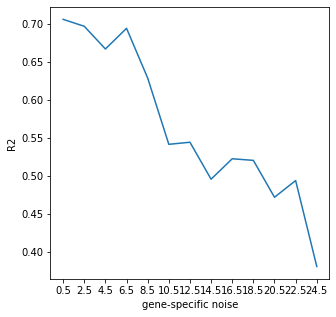

In [11]:
par_range = std_list
fig,ax = plt.subplots(figsize=(5,5))
plt.plot(par_range, out_l)
plt.xticks(par_range)
plt.xlabel('gene-specific noise')
plt.ylabel('R2')
plt.show()

In [12]:
#drop out percentages
std_list = np.arange(0.5, 15, 1.5)
std_list

array([ 0.5,  2. ,  3.5,  5. ,  6.5,  8. ,  9.5, 11. , 12.5, 14. ])

In [15]:
curr_l = adfn.return_files(s_data, 'SPATIAL-TRANSCRIPTOMICS', '*__gamma*')
out_l = [np.load(curr_l[i], allow_pickle=True)[2] for i in range(len(curr_l))]
curr_l

['RCTD-test_PARSTAND__gamma-std-8_alpha-std-00.5.npy',
 'RCTD-test_PARSTAND__gamma-std-8_alpha-std-02.0.npy',
 'RCTD-test_PARSTAND__gamma-std-8_alpha-std-03.5.npy',
 'RCTD-test_PARSTAND__gamma-std-8_alpha-std-05.0.npy',
 'RCTD-test_PARSTAND__gamma-std-8_alpha-std-06.5.npy',
 'RCTD-test_PARSTAND__gamma-std-8_alpha-std-08.0.npy',
 'RCTD-test_PARSTAND__gamma-std-8_alpha-std-09.5.npy',
 'RCTD-test_PARSTAND__gamma-std-8_alpha-std-11.0.npy',
 'RCTD-test_PARSTAND__gamma-std-8_alpha-std-12.5.npy',
 'RCTD-test_PARSTAND__gamma-std-8_alpha-std-14.0.npy']

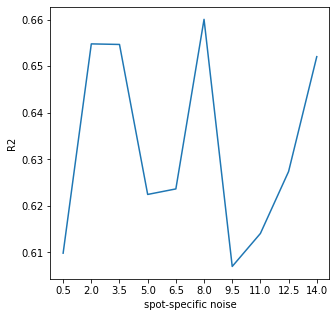

In [16]:

par_range = std_list
fig,ax = plt.subplots(figsize=(5,5))
plt.plot(par_range, out_l)
plt.xticks(par_range)
plt.xlabel('spot-specific noise')
plt.ylabel('R2')
plt.show()

# Bayesian inference with PyMC

In [2]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [36]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [34]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

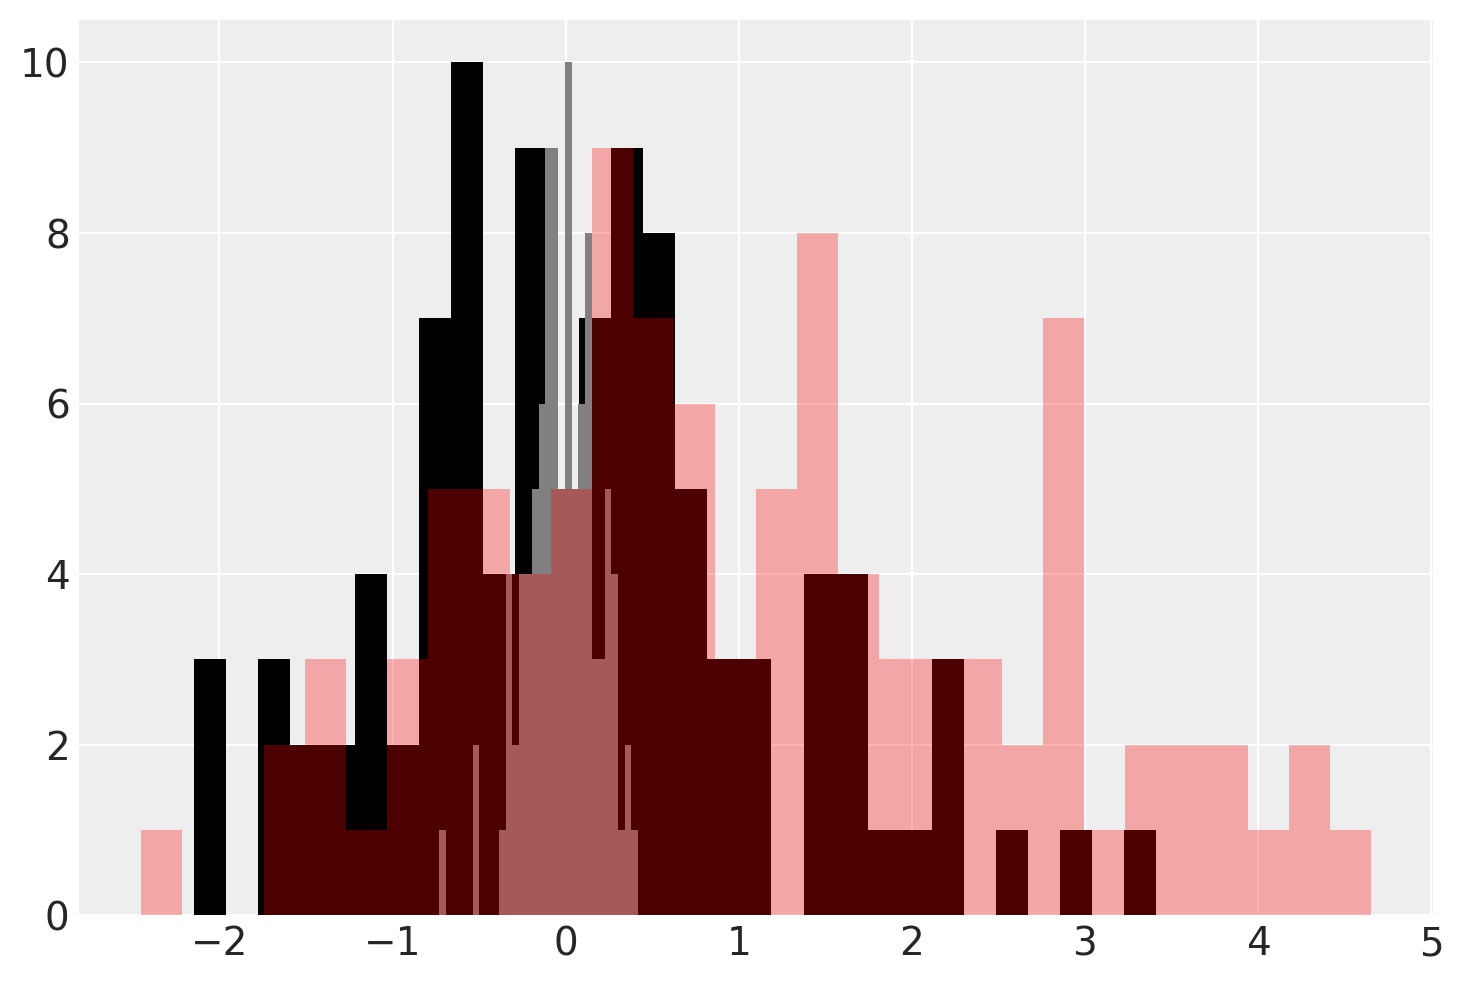

In [35]:
nbins = 30
plt.hist(X1, color='k', bins = nbins)
plt.hist(X2, color='grey', bins = nbins)
plt.hist(Y, color='red', bins = nbins, alpha = 0.3)

plt.show()

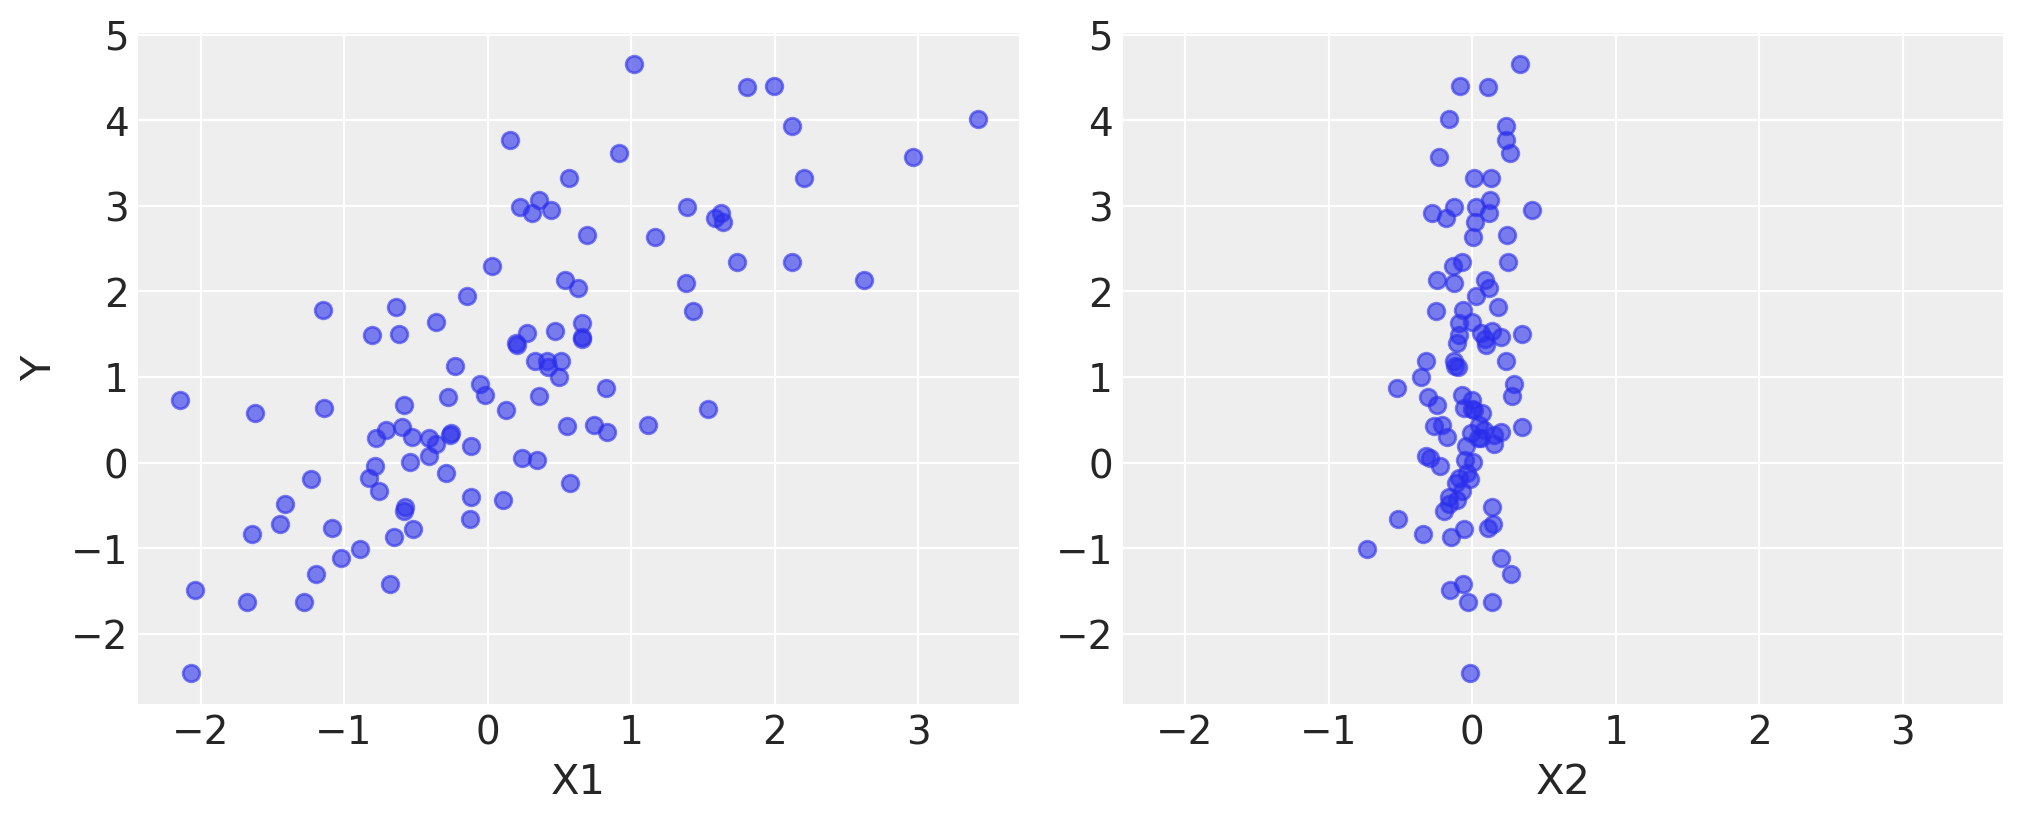

In [36]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [ ]:
basic_model = pm.Model()

with basic_model: #Creates new model object

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=5, sigma=1)
    beta = pm.Normal("beta", mu=5, sigma=1, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=100)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

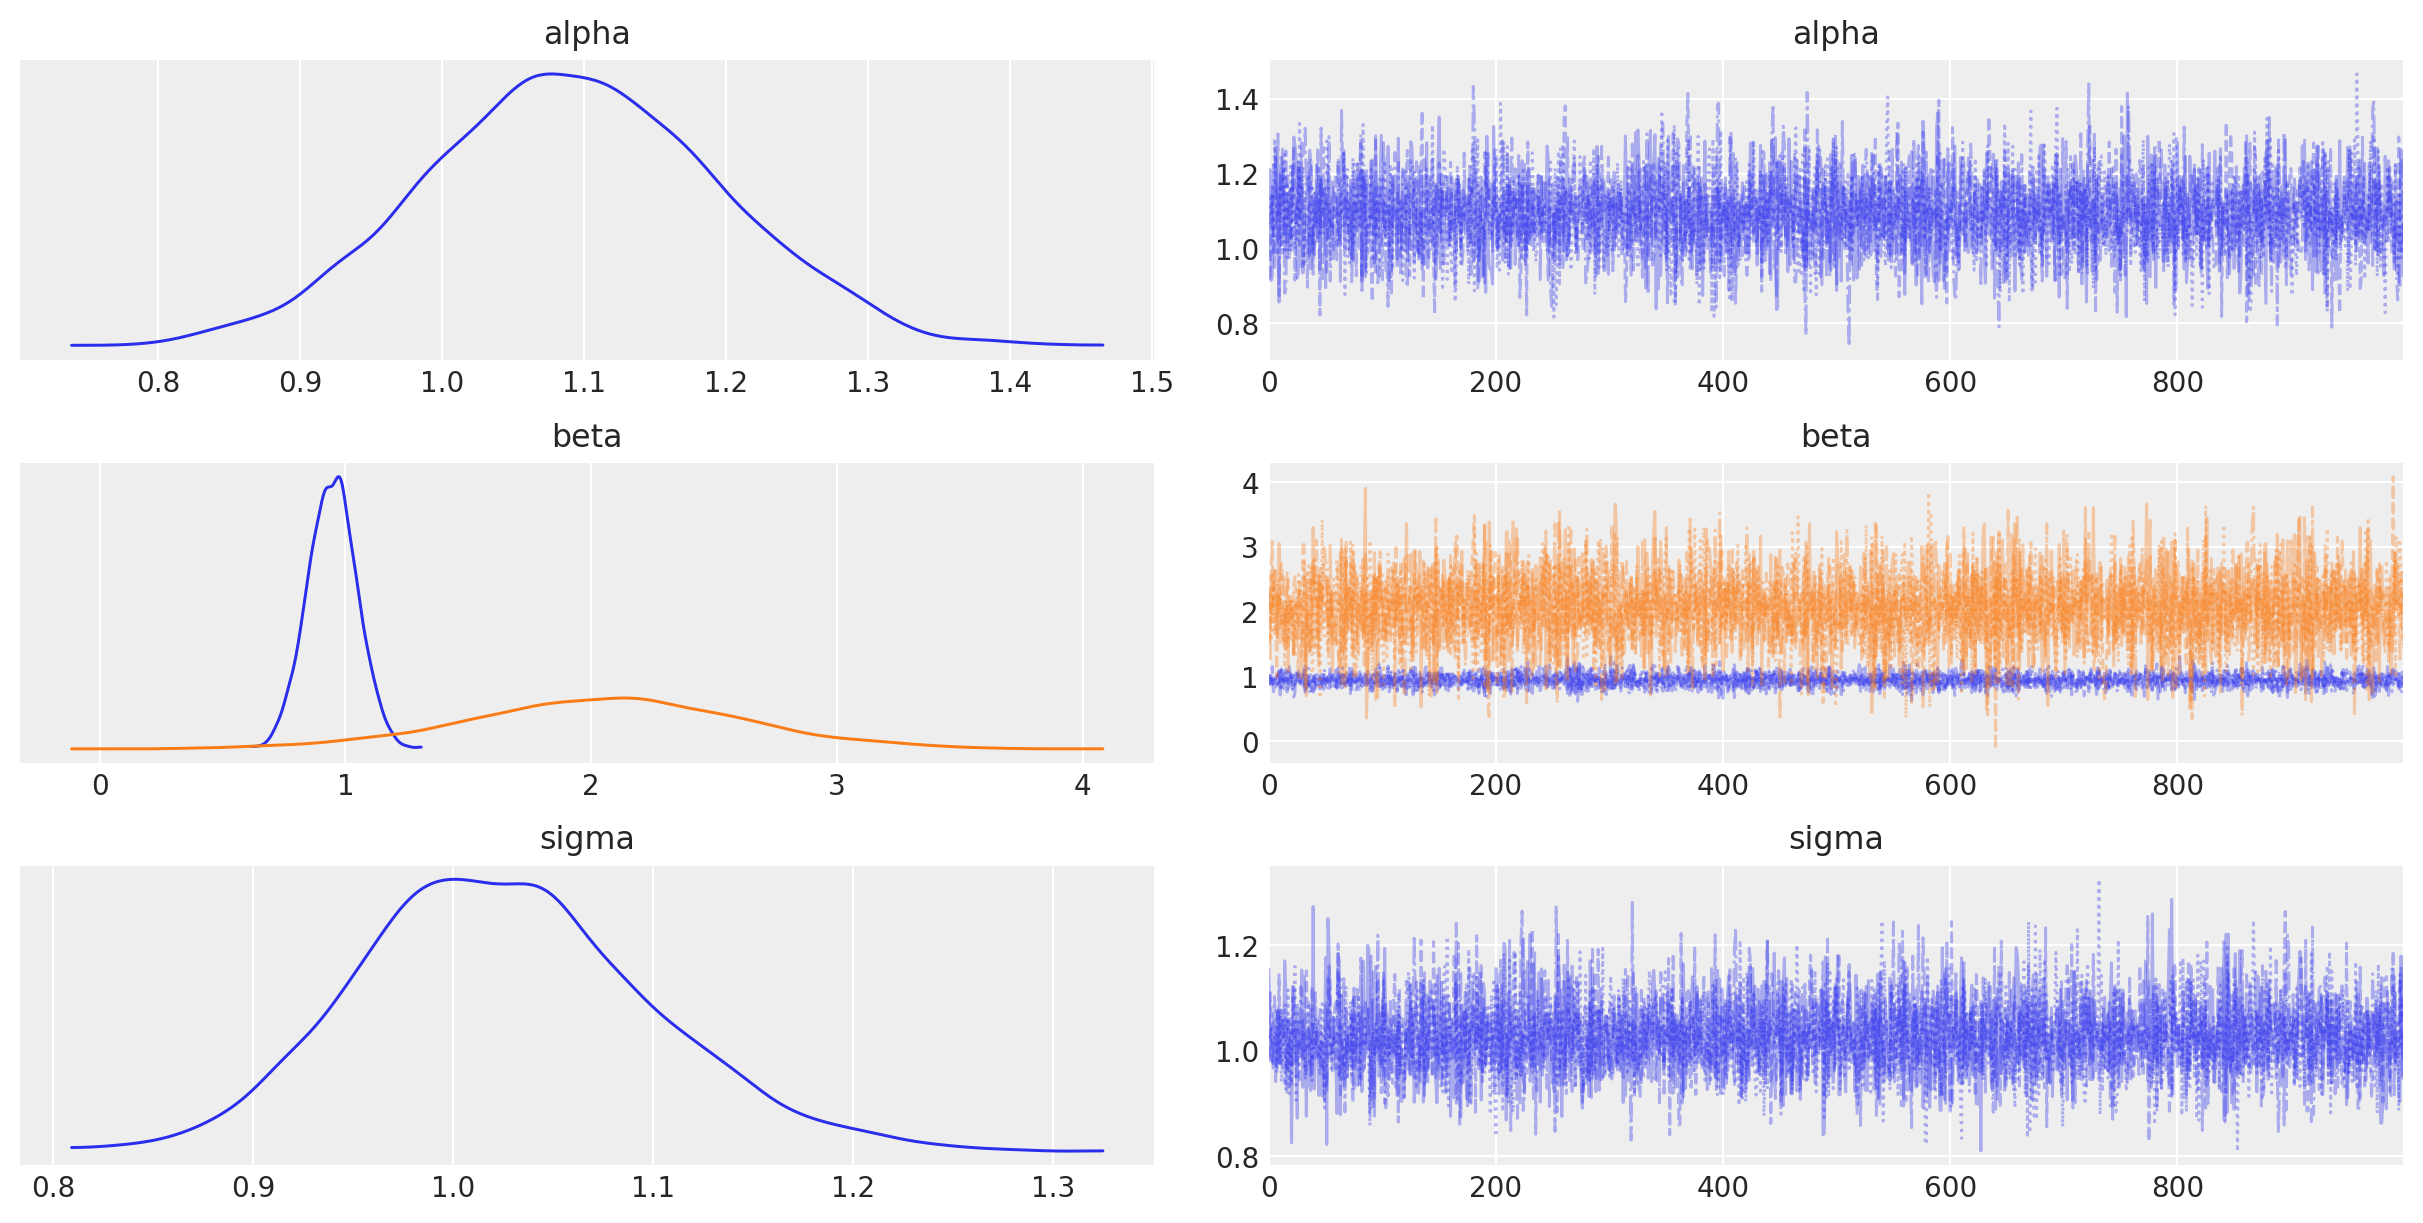

In [71]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag
az.plot_trace(idata, combined=True);

# Apply to neuronal activity data

In [4]:
data_l = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*regtrace*')
data_l

['BLNDEV-WILDTYPE-01_2photon_sess-01-4dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-01_2photon_sess-01-5dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-01_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-01_2photon_sess-01-7dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-01_2photon_sess-01-8dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-02_2photon_sess-01-3dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-02_2photon_sess-01-4dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-02_2photon_sess-01-5dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-02_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-03_2photon_sess-01-4dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-03_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-04_2photon_sess-01-4dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-04_2photon_sess-01-5dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-04_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-04

In [6]:
prac = np.load(data_l[0])
prac.shape

(15105, 4914)

In [25]:
Y = prac[0]
Y.shape

(4914,)

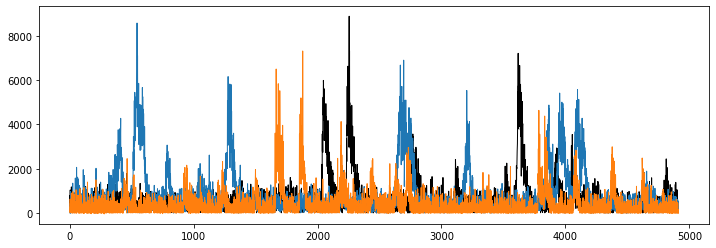

In [26]:
fig, axarr = plt.subplots(figsize = (12,4))
for i in range(3):
    if i ==0:
        plt.plot(prac[i], linewidth = 1, c = 'k')
    else:
        plt.plot(prac[i], linewidth = 1)

In [30]:
u  = np.mean(prac)

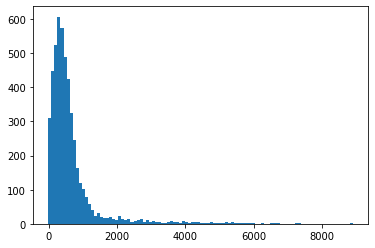

In [27]:
plt.hist(Y, bins = 100)
plt.show()

In [32]:
X1 = prac[1]
X2 = prac[2]
X1.shape, X2.shape, Y.shape

((4914,), (4914,), (4914,))

In [52]:
basic_model = pm.Model()

with basic_model: #Creates new model object

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=200, sigma=10)
    beta = pm.Normal("beta", mu=1, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=2)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [44]:
basic_model

In [53]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()


/Users/dominicburrows/Applications/anaconda3/lib/python3.7/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


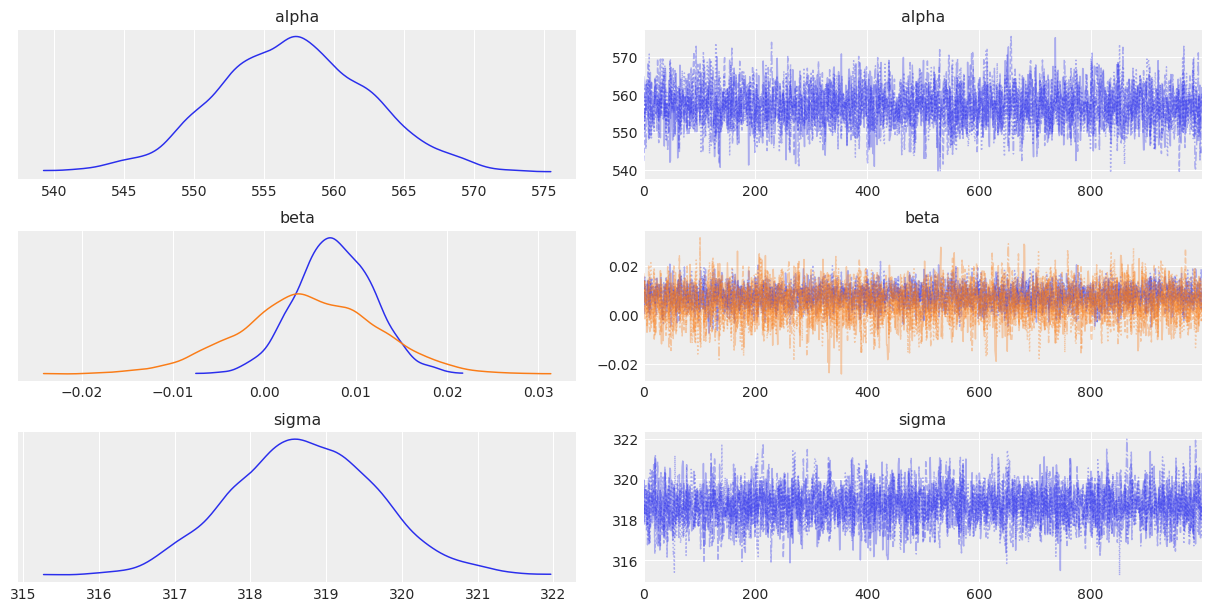

In [54]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag
az.plot_trace(idata, combined=True);

# Gaussian processes

In [40]:
from gp import GP, SquaredExponentialKernel
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Set values to model parameters.
lengthscale = 0.1
signal_variance = 10.
noise_variance = 0.1

# Create the GP.
kernel = SquaredExponentialKernel(
    lengthscale=lengthscale, signal_variance=signal_variance)
gp = GP(kernel=kernel, noise_variance=noise_variance)
n = 200
x = np.linspace(0, 2 * np.pi, n)
mean = np.zeros(n)
cov = gp.k(x, x)

# Draw samples from the GP prior.
probabilities = []
samples = []
jitter = np.eye(n) * 1e-6
for _ in range(20):
    y = multivariate_normal.rvs(mean=mean, cov=cov)
    # Add a jitter to the covariance matrix for numerical stability.
    prob = multivariate_normal.pdf(y, mean=mean, cov=cov + jitter)

    samples.append(y)
    probabilities.append(prob)

# Normalize sample probabilities into [0, 1].
probabilities = np.array(probabilities)
min_prob, max_prob = np.min(probabilities), np.max(probabilities)
probabilities = (probabilities - min_prob) / (max_prob - min_prob)
# Plotting.
ax = plt.gca()
for y, prob in zip(samples, probabilities):
    ax.plot(x, y, alpha=prob * 2)

ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

plt.show()


SyntaxError: invalid syntax (gp.py, line 105)

In [39]:
gp.k?

Object `gp.k` not found.


In [38]:
np.cov(x, x)

array([[3.33963029, 3.33963029],
       [3.33963029, 3.33963029]])

In [29]:
#from gp import GP, SquaredExponentialKernel
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Set values to model parameters.
lengthscale = 0.1
signal_variance = 10.
noise_variance = 0.1

# Create the GP.

n = 200
x = np.linspace(0, 2 * np.pi, n)
mean = np.zeros(n)
#cov = gp.k(x, x)


In [32]:
len(x), mean

(200,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [33]:

# Draw samples from the GP prior.
probabilities = []
samples = []
jitter = np.eye(n) * 1e-6
for _ in range(20):
    y = multivariate_normal.rvs(mean=mean, cov=cov)
    # Add a jitter to the covariance matrix for numerical stability.
    prob = multivariate_normal.pdf(y, mean=mean, cov=cov + jitter)

    samples.append(y)
    probabilities.append(prob)


NameError: name 'cov' is not defined

In [34]:
y = multivariate_normal.rvs?

Signature: multivariate_normal.rvs(mean=None, cov=1, size=1, random_state=None)
Docstring:
Draw random samples from a multivariate normal distribution.

Parameters
----------
mean : array_like, optional
    Mean of the distribution (default zero)
cov : array_like, optional
    Covariance matrix of the distribution (default one)
allow_singular : bool, optional
    Whether to allow a singular covariance matrix.  (Default: False)
size : integer, optional
    Number of samples to draw (default 1).
random_state : {None, int, `numpy.random.Generator`,
                `numpy.random.RandomState`}, optional

    If `seed` is None (or `np.random`), the `numpy.random.RandomState`
    singleton is used.
    If `seed` is an int, a new ``RandomState`` instance is used,
    seeded with `seed`.
    If `seed` is already a ``Generator`` or ``RandomState`` instance then
    that instance is used.

Returns
-------
rvs : ndarray or scalar
    Random variates of size (`size`, `N`), where `N` is the
    dime

In [ ]:
y = multivariate_normal.rvs